In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
siglist = [ (700,300,), (1000,450), (1200,500) ]
module = fc.eightb.preselection.ranked_quadh
get_fn = lambda module, mx, my: getattr(module, f"NMSSM_XYY_YToHH_8b_MX_{mx}_MY_{my}")
signal = ObjIter([ Tree(get_fn(module, mx, my), use_gen=False) for mx, my in siglist])

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


In [4]:
# bkg = ObjIter([ Tree(module.QCD_B_List, use_gen=False),Tree(module.TTJets, use_gen=False) ])
bkg = ObjIter([])


In [5]:
modules = dict(
  jhranker="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/weaver/models/jet_quadh_ranker/20220824-172231_ranger_lr0.0047_batch512_m10/",
)

signals = [ signal ] + [ signal.copy() for i in range(len(modules)-1) ]
bkgs = [ bkg ] + [ bkg.copy() for i in range(len(modules)-1) ]

for model, signal, bkg in zip(modules.values(), signals, bkgs):
  (signal+bkg).apply(lambda t : eightb.load_jet_quadh(t, model), report=True)

100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


In [6]:
use_bkg = any((any(bkg) for bkg in bkgs))
h_linestyle = [':','--','-'] if len(modules) == 3 else [':','-']
def compare_modules(var, bkg=use_bkg, figax=None, **kwargs):
  n = len(signals[0])+1 if bkg else len(signals[0])
  if figax is None:
    figax = study.get_figax(n, dim=(-1,n))
  fig, axs = figax
  
  label = list(modules.keys())

  for i, samples in enumerate(zip(*signals)):
    study.quick(
      list(samples), legend=True,
      label=label,
      h_linestyle=h_linestyle,
      varlist=[var],
      text=(0.0,1.0, samples[0].sample),
      text_style=dict(ha='left',va='bottom'),
      figax=(fig,axs.flat[i]),
      **kwargs,
    )

  if not bkg: return

  study.quick_region(
    *bkgs, legend=True,
    h_color=['grey']*3,
    label=label,
    h_linestyle=h_linestyle,
    varlist=[var],
    text=(0.0,1.0,'MC-Bkg'),
    text_style=dict(ha='left',va='bottom'),
    figax=(fig,axs.flat[-1]),
    **kwargs,
  )
def compare_samples(var, bkg=use_bkg, figax=None, efficiency=True, **kwargs):
  if figax is None:
    figax = study.get_figax(len(modules), dim=(-1,len(modules)))
  fig, axs = figax

  samples = signals

  if bkg:
    samples = [ sample+bkg for sample, bkg in zip(samples, bkgs)]
  label=list(modules.keys())

  for i, sample in enumerate(samples):
    ax = axs.flat[i] if len(modules) > 1 else axs
    study.quick(
      sample, legend=True, stacked=True,
      varlist=[var],
      # h_linestyle=[h_linestyle[i]]*sample.is_signal.npy.sum(),
      text=(0.0,1.0, label[i]),
      text_style=dict(ha='left',va='bottom'),
      efficiency=efficiency,
      figax=(fig,axs),
      **kwargs,
    )

In [7]:
dout = "comparing_rankers"

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


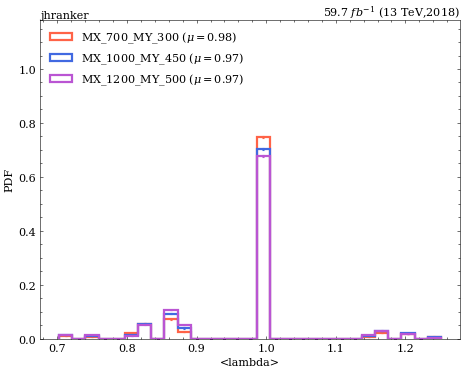

In [8]:
compare_samples(lambda t: ak.sum(t.jet_signalId>-1,axis=-1)/t.nfound_select, h_label_stat='mean')

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


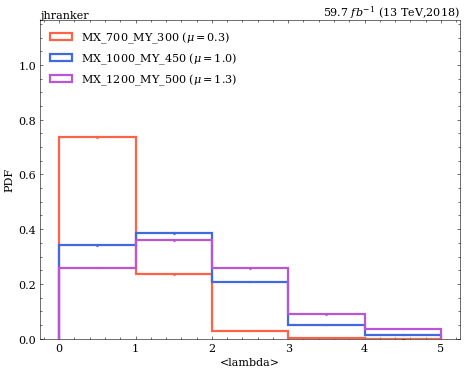

In [9]:
compare_samples(lambda t: ak.sum(t.dijet_signalId>-1,axis=-1), h_label_stat='mean')

In [10]:
(signal+bkg).apply(lambda t : t.extend(
  btagavg = ak.mean(t.jet_btag,axis=-1)
))

[None, None, None]

In [15]:
signal.apply(lambda t : ak.corr(t.jet_btag, t.jet_score))

[0.27372985578999115, 0.2870940731991272, 0.27868811203215943]